In [1]:
import os
import warnings
import numpy as np
import networkx as nx
from copy import deepcopy
from vbi.models.numba.mpr import MPR_sde
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")

In [2]:
np.random.seed(42)

In [3]:
def timer(func):
    def wrapper(*args, **kwargs):
        import time
        start = time.time()
        result = func(*args, **kwargs)
        print(f"{func.__name__} took {time.time() - start:.2f} seconds")
        return result
    return wrapper

In [4]:
@timer
def wrapper(g, par, close=True):
    par = deepcopy(par)
    sde = MPR_sde(par)
    control = {"G":g}
    data = sde.run(control)
    rv_t = data["rv_t"]
    rv_d = data["rv_d"]
    nn = par["weights"].shape[0]
    r = rv_d[:, :nn]
    v = rv_d[:, nn:]
    
    bold_d = data["bold_d"]
    bold_t = data["bold_t"]
    
    return rv_t, r, v, bold_t, bold_d

In [5]:
def plot(rv_t, r, v, bold_d, bold_t, g, close=True):
    step = 10
    fig, ax = plt.subplots(3, 1, figsize=(12, 6))
    ax[0].plot(rv_t[::step], r[::step, :], lw=0.1)
    ax[1].plot(rv_t[::step], v[::step, :], lw=0.1)
    ax[2].plot(bold_t, bold_d, lw=0.1)
    ax[0].set_ylabel("r")
    ax[1].set_ylabel("v")
    ax[2].set_ylabel("BOLD")
    # os.makedirs("data", exist_ok=True)
    # plt.savefig(f"data/control_vbi_{g:.3f}.png")
    # if close:
    #     plt.close()

In [16]:
nn = 6
weights = nx.to_numpy_array(nx.complete_graph(nn))
params = {"G": 0.01, 
          "weights": weights,
          "t_end": 10000,
          "dt": 0.01,
          "tau": 1.0,
          "eta": np.array([-4.6]),
          "rv_decimate": 10, # in time steps
          "noise_amp": 0.037,
          "tr": 100.0,        # in [ms] 
          "seed":42
          }

warm up

In [17]:
rv_t, r, v, bold_t, bold_d =  wrapper(0.33, params)

wrapper took 0.82 seconds


In [9]:
np.isnan(r).sum()

0

wrapper took 2.34 seconds


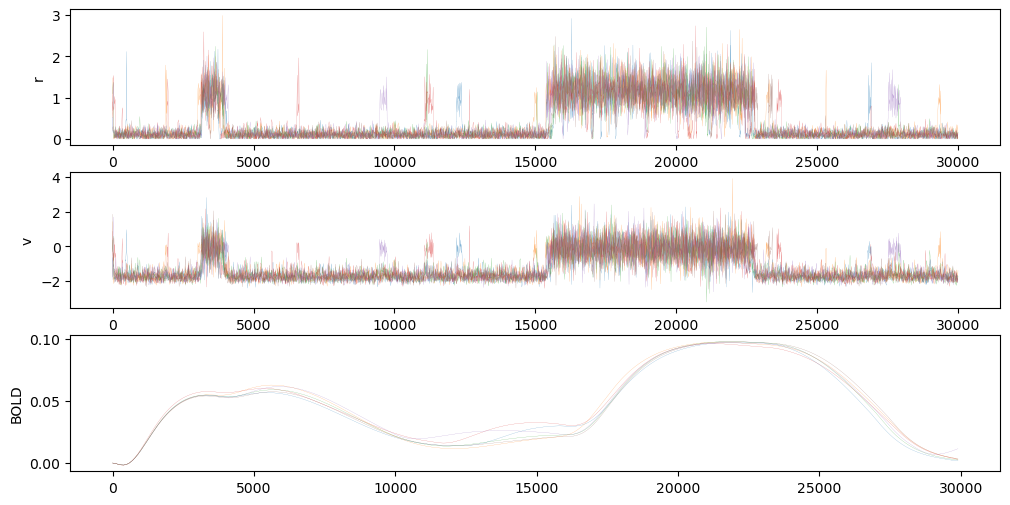

In [21]:
params['t_end'] = 30_000
g = 0.33
rv_t, r, v, bold_t, bold_d = wrapper(g, params)
plot(rv_t, r, v, bold_d, bold_t, g)

In [22]:
np.diff(rv_t)[:2], np.diff(bold_t[:2]), rv_t[0], rv_t[1], rv_t[-1]

(array([1., 1.], dtype=float32),
 array([100.], dtype=float32),
 0.0,
 1.0,
 29999.0)